# SENTIMENT ANALYSIS USING BERT (IMDB REVIEWS)
This project focuses on analyzing the IMDB Movie Reviews dataset using Natural Language Processing (NLP) techniques, particularly leveraging the power of BERT (Bidirectional Encoder Representations from Transformers).

The goal is to explore various insights such as sentiment analysis, emotion detection, aspect-based sentiment analysis, and more. Ultimately, the project aims to develop a robust sentiment analysis model to classify movie reviews as either positive or negative, providing both predictive capability and actionable insights from the dataset.

#### DATASET EXPLORATION

The IMDB dataset consists of 50,000 movie reviews labeled with their respective sentiments (positive or negative). This dataset is widely used for sentiment analysis tasks, helping to understand public opinion and develop applications such as recommendation systems or customer feedback analysis. The dataset includes two columns: the review text and its associated sentiment label.

In [21]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hide Warning Messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [22]:
import os
os.listdir('/kaggle/input/')

['IMDB Dataset.csv']

In [23]:
# Load Dataset
data = pd.read_csv('../input/IMDB Dataset.csv')
data.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [24]:
# Rows and Columns
data.shape

(50000, 2)


> The dataset contains 50,000 rows and 2 columns: review and sentiment.Each row represents a movie review paired with its sentiment label. The labels (positive or negative) make this a binary classification task.This structure ensures that the dataset is well-suited for text classification tasks, especially sentiment analysis.

To facilitate efficient experimentation, the dataset was downsampled to 3,000 reviews, ensuring an equal distribution of 1,500 positive and 1,500 negative reviews.

In [25]:
# Sample the Dataset
df = data.groupby('sentiment').sample(n=1500, random_state=42)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Value Counts
df['sentiment'].value_counts()

sentiment
positive    1500
negative    1500
Name: count, dtype: int64

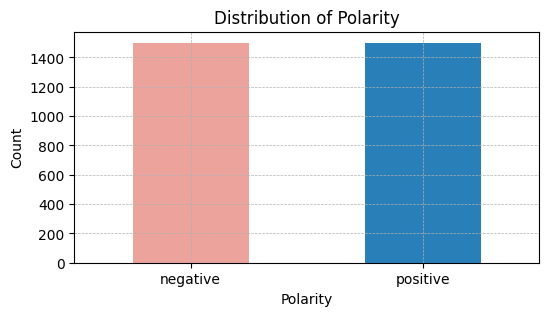

In [26]:
# Plot Distribution of Sentiment Polarity
plt.figure(figsize=(6, 3))
df['sentiment'].value_counts().sort_index().plot(kind='bar', color=['#eba39c', '#2980b9'])
plt.title('Distribution of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xticks(rotation=0)  # horizontal labels
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

>The sampled dataset maintains a balanced distribution of sentiments, with 1,500 reviews labeled as positive and 1,500 labeled as negative. The bar plot confirms this equal distribution, making the dataset ideal for binary classification without introducing class imbalance bias.

To ensure the dataset's integrity, missing values were checked across all columns. Missing values can significantly impact the training process, as they disrupt the input data's consistency.

In [27]:
# Check Missing Values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

>output confirms that there are no missing values in either the review or sentiment columns. This ensures the dataset is complete and ready for further preprocessing.

#### TEXT PREPROCESSING
To prepare the text data for analysis, the reviews were preprocessed to remove noise and standardize the text. This involved removing HTML tags, special characters, extra whitespaces, and converting all text to lowercase. Additionally, sentiment labels were encoded as numerical values (1 for positive and 0 for negative), ensuring compatibility with the model training process.

In [28]:
import re

# Define Text Cleaning Function
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove extra whitespaces
    text = text.strip()  # remove leading and trailing spaces
    return text.lower()  # convert to lowercase

# Apply Text Ceaning
df['review_cleaned'] = df['review'].apply(clean_text)

# Label Encoding
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.sample(3)

,review,sentiment,review_cleaned
1568,"Intelligent, stylish, and compelling thriller ...",1,intelligent stylish and compelling thriller fr...
2013,This is truly the greatest Swedish movie of al...,1,this is truly the greatest swedish movie of al...
929,I love this movie!! Sure I love it because of ...,1,i love this movie sure i love it because of ma...


#### CHECKING REVIEW LENGTH
Understanding the distribution of review lengths provides insights into the dataset's structure and helps set appropriate tokenization parameters for the model. Reviews that are too long may need truncation, while very short reviews might contribute less meaningful information.

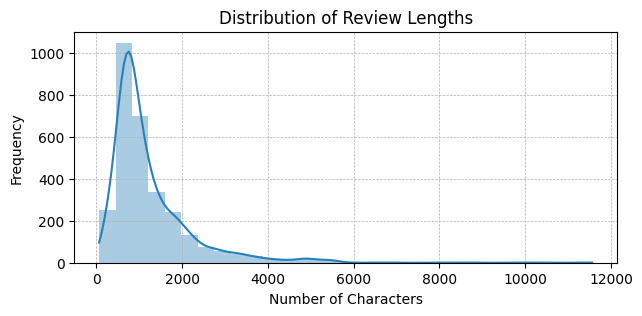

In [29]:
# Count Review Length
df['review_length'] = df['review_cleaned'].apply(len)

# Distribution of Review Lengths
plt.figure(figsize=(7, 3))
sns.histplot(df['review_length'], bins=30, kde=True, color='#2980b9', edgecolor=None, alpha=0.4)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [30]:
df['review_length'].describe()

count     3000.000000
mean      1224.151000
std        945.089964
min         63.000000
25%        665.750000
50%        905.000000
75%       1464.000000
max      11562.000000
Name: review_length, dtype: float64

>The distribution of review lengths shows that most reviews fall between 500 and 1,500 characters, with the longest review being over 11,500 characters. The summary statistics reveal the mean review length is approximately 1,224 characters, with a standard deviation of 945. This variability highlights the need for preprocessing steps like truncation or padding during tokenization to ensure uniform input lengths for the BERT model.

#### DATA SPLITTING
To prepare the data for training and evaluation, the dataset was split into training, validation, and test sets. This ensures that the model is evaluated on unseen data, providing a reliable measure of its generalization capabilities. The split was performed as follows:

70% of the data was allocated for training.
The remaining 30% was split equally into validation and test sets.

In [31]:
from sklearn.model_selection import train_test_split

# Split Data fot Training and Temporary
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['review_cleaned'],  df['sentiment'], test_size=0.3, random_state=42
    )

# Split Data for Validation and Test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
    )

print(f"Training Set: {len(train_texts)} samples")
print(f"Validation Set: {len(val_texts)} samples")
print(f"Test Set: {len(test_texts)} samples")

Training Set: 2100 samples
Validation Set: 450 samples
Test Set: 450 samples


>The training set contains 2,100 samples, while the validation and test sets each contain 450 samples. This ensures that the model has sufficient data for training while reserving separate datasets for fine-tuning hyperparameters and evaluating final performance.

#### TOKENIZATION WITH BERT
Tokenization is a crucial step in preparing the text data for BERT. The BERT tokenizer breaks down each review into tokens while adding special tokens required by the BERT model. The tokenizer also ensures that input sequences are of uniform length by truncating or padding them to a specified maximum length.

In [32]:
from transformers import BertTokenizer

# Initialize BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define Function for Tokenization
def tokenize_reviews(reviews, max_length=128):
    return tokenizer(
        reviews.tolist(),
        padding='max_length',  # pad sequences to the same length
        truncation=True,       # truncate sequences longer than max_length
        max_length=max_length, # maximum sequence length
        return_tensors="pt"    # return PyTorch tensors
    )

# Tokenizing the Training, Validation, and Test Sets
train_encodings = tokenize_reviews(train_texts)
val_encodings = tokenize_reviews(val_texts)
test_encodings = tokenize_reviews(test_texts)

#### PREPARING DATASET OBJECTS
To utilize the tokenized data for training and evaluation, it is organized into dataset objects compatible with PyTorch. These objects are instances of a custom dataset class that returns tokenized inputs and their corresponding labels, facilitating efficient batching and processing.

In [33]:
import torch
from torch.utils.data import Dataset

# Custom Dataset class
class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Prepare Dataset Objects
train_dataset = IMDBDataset(train_encodings, train_labels.tolist())
val_dataset = IMDBDataset(val_encodings, val_labels.tolist())
test_dataset = IMDBDataset(test_encodings, test_labels.tolist())

#### LOAD AND SETUP BERT MODEL
This section involves preparing the pre-trained BERT model with a classification head for binary sentiment analysis, defining a DataLoader to batch data efficiently during training and validation (default batch size: 64), using the AdamW optimizer with a learning rate of 1e-5 for parameter updates, and employing CrossEntropyLoss to compute errors between predictions and actual labels. These steps collectively prepare the model and data pipeline for effective training and validation.

In [34]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader

# Load Pre-trained BERT Model with Classification Head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define DataLoader for Batching
def create_data_loader(dataset, batch_size=64):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Apply Dataloader in Datasets
train_loader = create_data_loader(train_dataset)
val_loader = create_data_loader(val_dataset)
test_loader = create_data_loader(test_dataset)

# Define Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### TRAINING-VALIDATION LOOP
A custom training loop is implemented to train the BERT model and track its performance. The training loop involves forward and backward passes for the training set and evaluates model performance on the validation set at the end of each epoch.  
Training Phase: The model makes predictions on batches of training data, calculates the loss, and updates weights using the optimizer.  
Validation Phase: The model is evaluated on the validation set to calculate validation loss and accuracy without updating weights.  
Performance Tracking: At each epoch, training loss, validation loss, and validation accuracy are logged to monitor the model's learning progress.

In [35]:
# Training Validation Loop
def train_model_with_metrics(model, train_loader, val_loader, optimizer, loss_fn, epochs=3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs)
                loss = loss_fn(outputs.logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

In [36]:
# Train Model and Collect Metrics
train_losses, val_losses, val_accuracies = train_model_with_metrics(model, train_loader, val_loader, optimizer, loss_fn)

Epoch 1/3
Train Loss: 0.6561, Validation Loss: 0.5758, Validation Accuracy: 0.7178
Epoch 2/3
Train Loss: 0.4681, Validation Loss: 0.3897, Validation Accuracy: 0.8244
Epoch 3/3
Train Loss: 0.3177, Validation Loss: 0.3394, Validation Accuracy: 0.8422


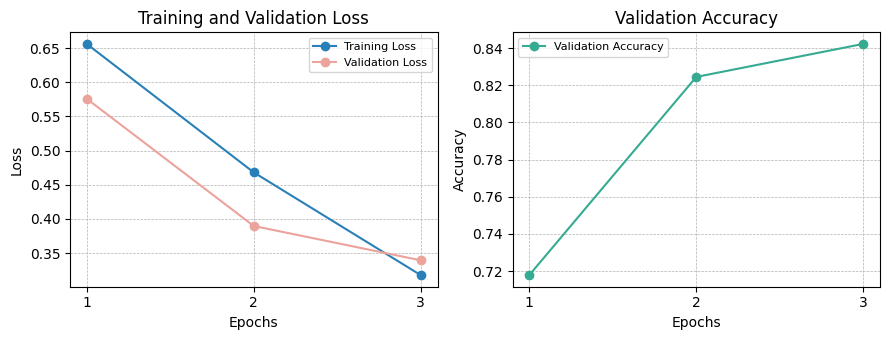

In [37]:
# Plot Training Results
metrics = [
    (train_losses, val_losses, 'Loss', 'Training and Validation Loss', ['Training Loss', 'Validation Loss']),
    (val_accuracies, None, 'Accuracy', 'Validation Accuracy', ['Validation Accuracy'])
]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))

# Plot each metric using a loop
for i, (metric1, metric2, ylabel, title, labels) in enumerate(metrics):
    axes[i].plot(range(1, len(metric1) + 1), metric1, label=labels[0], color='#2980b9' if i == 0 else '#36ab92', marker='o')
    if metric2 is not None:
        axes[i].plot(range(1, len(metric2) + 1), metric2, label=labels[1], color='#eba39c', marker='o')
    axes[i].set_title(title)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(ylabel)
    axes[i].set_xticks(range(1, len(metric1) + 1))
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.show()

>The results indicate that the training loss decreases steadily, showing effective learning by the model. Validation loss and accuracy stabilize after the second epoch, demonstrating the model’s ability to generalize well to unseen data.

#### MODEL EVALUATION
The model is evaluated on the test set to measure its generalization performance. This step involves computing the test loss and accuracy without updating the model’s weights. The evaluation process ensures that the model’s predictions align well with the ground truth on unseen data.

In [38]:
# Evaluate on Test Set
def evaluate_on_test_set(model, test_loader, loss_fn, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            test_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [39]:
evaluate_on_test_set(model, test_loader, loss_fn)

Test Loss: 0.3256, Test Accuracy: 0.8422


>The model achieves a test accuracy of 84.22%, demonstrating good generalization to unseen data. The test loss indicates that the model's predictions are reasonably close to the true labels, confirming its robustness and reliability for binary sentiment classification.

